In [1]:
import json
import os
from flask import Flask, render_template, request
from flask_cors import CORS
# from helpers.similarity import get_title_sim, cossim_scores
from helpers import preprocessing, similarity
import pandas as pd
from collections import defaultdict

In [2]:
with open("init.json", 'r') as file:
    data = json.load(file)
    kdramas_df = pd.DataFrame(data)


In [3]:
def cossim_search(query):
    inv_idx = preprocessing.build_inverted_index(kdramas_df['synopsis'])
    idf_dict = preprocessing.compute_idf(inv_idx, len(kdramas_df['synopsis']))
    doc_norms = preprocessing.compute_doc_norms(inv_idx, idf_dict, len(kdramas_df['synopsis']))
    scores = similarity.index_search(query, inv_idx, idf_dict, doc_norms)
    doc_ids = [doc_id for _, doc_id in scores]
    ranked_docs = kdramas_df.iloc[doc_ids]
    matches_filtered = ranked_docs if not ranked_docs.empty else kdramas_df
    matches_filtered_json = matches_filtered.to_json(orient='records')
    return [(score, kdramas_df.iloc[id]["name"]) for score, id in scores]

cossim_search("squid")

TypeError: build_inverted_index() missing 1 required positional argument: 'terms'

In [291]:
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .6,
                            min_df = 1)
korean_names = set([
  "kim", "lee", "park", "choi", "jung", "kang", "cho", "yoon", "jang", "im",
  "oh", "han", "seo", "shin", "kwon", "hwang", "ryu", "baek", "nam", "song",
  "hong", "yang", "an", "jeon", "lim", "ha", "no", "gu", "ma", "bang", "seok",
  "min", "joon", "ji", "hyun", "young", "seong", "jin", "myung", "tae", "woo",
  "soo", "hoon", "eun", "hye", "yoon", "hwan", "yeon", "in", "kyu", "byung",
  "chan", "sang", "dong", "il", "ki", "geun", "nam", "won", "ha", "hae",
  "mi", "na", "ra", "ah", "eun", "hye", "yeon", "hee", "kyung", "so", "jung",
  "da", "bo", "a", "seul", "yu", "chae", "rin", "su", "seo", "joo", "bin",
  "ye", "ga", "sa", "ha", "hwa", "ri", "ara", "do", "i", "bi", "nari",
  "jae", "ho", "hyuk", "seok", "hyun", "beom", "sik", "chul", "taek", "gyoon",
  "man", "rok", "hak", "wook", "jong", "kyoo", "suk", "shik", "geon", "yeop",
  "cheol", "bok", "mun", "pil", "jin", "han", "dong", "seung", "yong", "gyu",
  "geu", "roo", "shi", "lee", "yeo", "ri", "cha", "jo", "sung", "dae", "seon", "bong", "yeol"
  ,"yi","yoo","moo","se", "yeong", "goo", "ri", "ja", "ri"]
)
def preprocess(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in text.lower().split()])
def clean_synopsis(text):
    return " ".join(word for word in preprocessing.strip_text(text) if word.lower() not in korean_names)
kdramas_df["svd_synopsis"] = kdramas_df["synopsis"].apply(clean_synopsis)
td_matrix = vectorizer.fit_transform(kdramas_df["svd_synopsis"])
print(kdramas_df["svd_synopsis"])
u, s, v_trans = svds(td_matrix, k=100)
print(u.shape)
print(s.shape)
print(v_trans.shape)

0       is autistic 20 year old he works for his fathe...
1       is model student who ranks at the top of his h...
2       everyday is extraordinary for five doctors and...
3       although hui is hiding dark secret surrounding...
4       the stories of people going through their days...
                              ...                        
1642    the two best friends are polar opposites cin d...
1643    made it big after writing several thriller nov...
1644    sherlock k is beautiful woman disguised as com...
1645    story about girl minsun getting revenge on her...
1646    the story of handsome genius and woman who is ...
Name: svd_synopsis, Length: 1643, dtype: object
(1643, 100)
(100,)
(100, 10565)


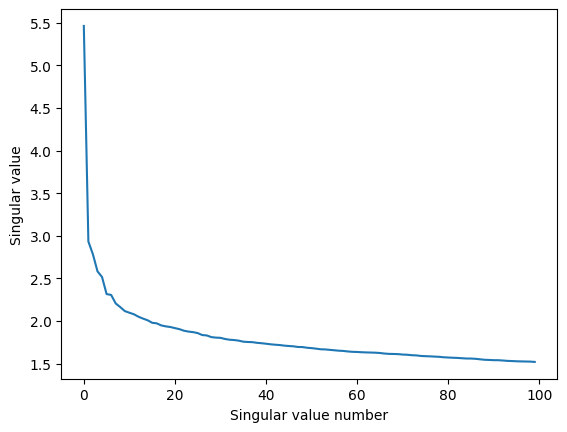

In [158]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd
docs_compressed, s, words_compressed = randomized_svd(td_matrix, n_components=20, random_state=42)
words_compressed = words_compressed.transpose()
td_matrix_np = td_matrix.transpose()
td_matrix_np = normalize(td_matrix_np)
query = "doctor vaccines disease"
query_tfidf = vectorizer.transform([query]).toarray()
print(query_tfidf.shape)
print(words_compressed.shape)
print(docs_compressed[0]
)
query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()
print(query_vec)
docs_compressed_normed = normalize(docs_compressed)
word_to_index = vectorizer.vocabulary_

index_to_word = {i:t for t,i in word_to_index.items()}
for i in range(20):
    print("Top words in dimension", i)
    dimension_col = words_compressed[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:20]])
    print()

(1, 10565)
(10565, 20)
[ 0.02124877 -0.02335988 -0.01638634  0.01606813 -0.0105347  -0.00757369
  0.01817309  0.02329455 -0.04282737 -0.00048136 -0.02111918 -0.02833849
 -0.03417719 -0.00522468  0.02151886 -0.02655527  0.01598133 -0.01969147
  0.00632052  0.03817019]
[ 0.14089812 -0.14026609 -0.14169968  0.05264036  0.01207715 -0.04440092
  0.04902835  0.03293219 -0.15217792 -0.51450359  0.10907123 -0.4356968
  0.28037851 -0.02282385  0.38241682  0.2807639   0.28417178 -0.17869732
  0.11306249 -0.11288908]
Top words in dimension 0
['love', 'life', 'family', 'school', 'time', 'story', 'years', 'drama', 'father', 'high', 'woman', 'people', 'mother', 'day', 'old', 'meets', 'new', 'daughter', 'son', 'year']

Top words in dimension 1
['school', 'high', 'student', 'students', 'friends', 'teacher', 'romance', 'class', 'story', 'girl', 'old', 'year', 'college', 'popular', 'friendship', 'boys', 'friend', 'love', 'tells', 'web']

Top words in dimension 2
['love', 'story', 'drama', 'romance', 're

In [299]:
def get_top_latent_dims(query:str, vectorizer, td_matrix):
    docs_compressed, _, words_compressed = randomized_svd(td_matrix, n_components=20, random_state=42)
    words_compressed = words_compressed.transpose()

    query_tfidf = vectorizer.transform([query]).toarray()

    query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()

    query_vec = np.array(query_vec)
    valid_dims = [1,2,3,4,5,6,8,11,12,13,16,17,18,19]
    query_vec = query_vec[valid_dims]
    indices = np.argsort(query_vec)[-3:][::-1]
    index_to_index = {
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6,
    6: 8,
    7: 11,
    8: 12,
    9: 13,
    10: 16,
    11: 17,
    12: 18,
    13: 19
}
    word_to_index = vectorizer.vocabulary_
    index_to_word = {i:t for t,i in word_to_index.items()}
    list_of_asorts = [ np.argsort(-words_compressed[:,index_to_index[index]].squeeze()) for index in indices]
    latent_words = [ [index_to_word[i] for i in asort[:20]] for asort in list_of_asorts]

    index_to_genre = {0: "School", 1: "Romance", 2: "Family", 3:"Historical", 4: "Drama", 5: "Thriller", 6: "Life", 7: 'Chaebol', 8:"Medical", 9:"Friends", 10: "Law", 11:"Daughter/Mother", 12:"College", 13:"Father/Son"}

    genres = [index_to_genre[index] for index in indices]
    values = query_vec[indices]
    return list(zip(genres, values, latent_words))

print(get_top_latent_dims("vaccine doctor surgery", vectorizer,td_matrix))

[('Law', np.float64(0.3256621410536623), ['law', 'sun', 'lawyer', 'firm', 'year', 'prosecutor', 'doctor', 'girl', 'justice', 'case', 'hospital', 'students', 'medical', 'college', 'university', 'gets', 'house', 'power', 'personality', 'office']), ('Medical', np.float64(0.2656827967747752), ['korea', 'south', 'north', 'korean', 'sun', 'hospital', 'doctor', 'police', 'husband', 'students', 'life', 'married', 'detective', 'new', 'officer', 'medical', 'university', 'past', 'son', 'chef']), ('College', np.float64(0.1133386050721345), ['students', 'daughter', 'college', 'house', 'mother', 'university', 'story', 'time', 'father', 'different', 'years', 'later', 'couple', 'stories', 'detective', 'job', 'works', 'girl', 'day', 'begins'])]


In [247]:
kdramas_df = preprocessing.process_data(data)
vectorizer, synopsis_td_mat, terms = preprocessing.build_td_mat(kdramas_df)
inv_idx = preprocessing.build_inverted_index(synopsis_td_mat, terms)
doc_norms = preprocessing.compute_doc_norms(synopsis_td_mat)
text = "drama"
print(similarity.get_sim(text.lower(), kdramas_df, synopsis_td_mat, inv_idx, terms, doc_norms, vectorizer))

[{"id":576,"name":"Sweet Revenge","year":"2017","genres":["Comedy","Romance","Youth","Fantasy"],"mainCast":["Kim Hyang Gi","Lomon","Cha Eun Woo","Kim Hwan Hee","Park Kyung Rim","Ji Gun Woo"],"synopsis":"This web drama is a teen fantasy drama about a teenager who gets her hands on a note that enacts revenge on anyone whose name is written on it. ","score":"7.9","contentRating":"13+ - Teens 13 or older","tags":["High School","School Bullying","Revenge","Nice Male Lead","Friends To Lovers","Sismance","Mobile App","Break Up","Cheating","Web Series"],"network":["Apple TV","Tubi","AsianCrush","Viki"],"img":"https:\/\/i.mydramalist.com\/2q5zWc.jpg?v=1","episodeCount":"22 episodes","simScore":0.4550689247},{"id":1063,"name":"Bravo My Life","year":"2017","genres":["Drama","Family"],"mainCast":["Do Ji Won","Park  Sang Min","Yeon Jung Hoon","Jung Yoo Mi","Hyun Woo","Kang Ji Sub"],"synopsis":"\"A heady drama producer, an assistant director, and an actor who hasnt debuted after seven years in the i